In [63]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import GPyOpt
import GPy

import scipy as sp
from scipy.optimize import basinhopping
from numba import jit

## def objective

In [110]:
objective_true  = GPyOpt.objective_examples.experiments2d.sixhumpcamel()               # true function
objective_noisy = GPyOpt.objective_examples.experiments2d.sixhumpcamel()         # noisy version
bounds = objective_true.bounds     

In [117]:
objective_true  = GPyOpt.objective_examples.experiments2d.mccormick()               # true function
objective_noisy = GPyOpt.objective_examples.experiments2d.mccormick()         # noisy version
bounds = objective_true.bounds     

In [131]:
objective_true  = GPyOpt.objective_examples.experiments2d.powers()               # true function
objective_noisy = GPyOpt.objective_examples.experiments2d.powers()         # noisy version
bounds = objective_true.bounds     

In [125]:
objective_true  = GPyOpt.objective_examples.experiments2d.eggholder()               # true function
objective_noisy = GPyOpt.objective_examples.experiments2d.eggholder()         # noisy version
bounds = objective_true.bounds     

In [98]:
norm = False
objective_true  = GPyOpt.objective_examples.experiments2d.branin(bounds=[(-5, 10), (1, 15)],normalized = norm)               # true function
objective_noisy = GPyOpt.objective_examples.experiments2d.branin(bounds=[(0, 1), (0, 1)],sd = 0.0001,normalized = norm)         # noisy version
bounds = objective_true.bounds     

In [132]:
objective_true.f(minimize(objective_true.f,bounds,grid=100))

array([[0.00010306]])

In [133]:
bounds

[(-1, 1), (-1, 1)]

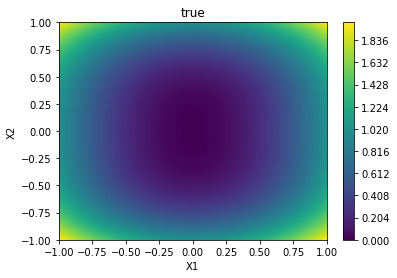

In [134]:
grid = 500
x1 = np.linspace(bounds[0][0], bounds[0][1], grid)
x2 = np.linspace(bounds[1][0], bounds[1][1], grid)
X1, X2 = np.meshgrid(x1, x2)
_X = np.hstack((X1.reshape(grid*grid,1),X2.reshape(grid*grid,1)))
_Y = objective_true.f(_X)

plt.figure()    
plt.contourf(X1, X2, _Y.reshape((grid,grid)),grid)
plt.colorbar()
plt.xlabel('X1')
plt.ylabel('X2')
plt.title("true")
plt.show()

In [5]:
bounds

[(0, 10), (0, 10)]

In [6]:
def generate_init(bounds, initial_n):
    dim = len(bounds)
    init_x = np.random.rand(initial_n, dim)
    for i in range(dim):
        init_x[:,i]=init_x[:,i]*(bounds[i][1]-bounds[i][0])+bounds[i][0]
    return init_x

In [67]:
generate_init(bounds, 1)

array([[0.78630599, 0.8662893 ]])

In [7]:
h=2
N = 12

In [8]:
def bayesianOptimization(func_objective,
                         func_acq,
                         bounds,
                         kernel,
                         depth_h,
                         N,
                         initial_n=1,
                         N_q=3):
    """
    depth_h: num of nest
    N: num of iter
    """
    if depth_h > N:
        print("depth_h > N")
        return 0
    elif initial_n > N:
        print("initial_n > N")
        return 0
    
    _N = N - initial_n
    queries = generate_init(bounds, initial_n)
    values = func_objective(queries)
    for i in range(_N):
        print(i)
        kernel = GPy.kern.RBF(len(bounds), ARD=True)
        #gp_model = fit(queries, values)
        _h = min({depth_h,_N-i})
        _count_depth = 0
        _gp_list = {}
        _queries_list = {}
        _values_list = {}
        _trajectory = []
        #_idlist = []
        if func_acq == ei:
            GP_model = fit(queries, values, kernel)
            facq = lambda x : -1*ei(x,bounds,GP_model)
        else:
            facq = lambda x : -1*func_acq(x, 
                                      bounds = bounds,
                                      func_policy=policy, 
                                      depth_h = _h, 
                                      _queries = queries,
                                      _values = values,
                                      kernel = kernel,
                                      N_q = N_q)
        X = minimize(facq, bounds)
        Y = func_objective(X)
        queries = np.concatenate([queries,X])
        values = np.concatenate([values,Y])
    return queries, values

In [9]:
#@jit
def policy(GP_model, depth_h,bounds):
    # caluc policy function
    if depth_h > 1:
        func2minimize = lambda x : -1*ei(x,bounds,GP_model)
    else:
        func2minimize = lambda x : mu(x,bounds,GP_model)
    query = minimize(func2minimize, bounds)
    return query

In [10]:
#Done: 獲得価値観数EI
@jit
def ei(x,bounds,GP_model,jitter=0.):
    if len(x.shape) == 1:
        x = np.array([x])
    mu, sig = GP_model.predict(x)
    fmin = GP_model.predict(GP_model.X)[0].min()
    if isinstance(sig, np.ndarray):
        sig[sig<1e-10] = 1e-10
    elif sig< 1e-10:
        sig = 1e-10
    u = (fmin - mu - jitter)/sig
    phi = np.exp(-0.5 * u**2) / np.sqrt(2*np.pi)
    Phi = 0.5 * sp.special.erfc(-u / np.sqrt(2))
    next_x = sig * (u * Phi + phi)
    return next_x

In [11]:
#Done: 獲得価値観数 mean
@jit
def mu(x, bounds, GP_model):
    if len(x.shape) == 1:
        x = np.array([x])
    mu = GP_model.predict(x)[0]
    return mu

In [12]:
@jit
def rollout_utility(x,
                    bounds,
                    func_policy, 
                    depth_h, 
                    _queries, 
                    _values, 
                    kernel,
                    N_q,
                    decay_rate=0.9):
    global _h
    global _gp_list
    global _queries_list
    global _values_list
    global _trajectory
    if len(x.shape) == 1:
        x = np.array([x])
    if depth_h == 0:
        gp_model = fit(_queries, _values, kernel)
        U = ei(x,bounds ,gp_model)
    else:    
        curr_depth = _h - depth_h #current depth
        _queries = np.concatenate([_queries,x])
        U = ei(x,bounds, gp_model)
        # GaussHermite
        points, weights = gauss_hermite(x, gp_model, N_q)
        for i in range(N_q):
            _trajectory.append(str(i))
            #_queries = np.concatenate([_queries,x])
            _id = str(curr_depth) + "".join(_trajectory)
            if _id in _gp_list:
                #gp_model = _gp_list[_id]
                #_queries = _queries_list[_id]
                _values = _values_list[_id]
            else:
                estimated_value = np.array([[points[0][i]]])
                _values = np.concatenate([_values, estimated_value])
                _gp_model = fit(_queries, _values, kernel) #memo
                x_next = func_policy(_gp_model, depth_h)
                
                _gp_list[_id] = _gp_model
                _values_list[_id] = _values
                
            U = U + decay_rate*rollout_utility(x_next,
                                            bounds,
                                            func_policy,
                                            depth_h-1,
                                            _queries,
                                            _values,
                                            kernel,
                                            N_q,
                                            decay_rate )
            U = weights[i]*U
            _values = _values[:-1,:]
            _trajectory.pop(-1)
        _queries = _queries[:-1,:]
    return U(x)

In [13]:
@jit
def rollout_utility_archive(x,
                    bounds,
                    func_policy, 
                    depth_h, 
                    _queries, 
                    _values, 
                    kernel,
                    N_q,
                    decay_rate=0.9,
                    ARD_Flag = True):
    #print("depth",depth_h)
    if len(x.shape) == 1:
        x = np.array([x])
    kernel = GPy.kern.RBF(len(bounds), ARD=ARD_Flag) #todo: fuck!!
    gp_model = fit(_queries, _values, kernel) #todo:memo
    if depth_h == 0:
        U = ei(x,bounds ,gp_model)
    else:
        U = ei(x,bounds, gp_model)
        _queries = np.concatenate([_queries,x])
        points, weights = gauss_hermite(x, gp_model, N_q)
        for i in range(N_q):
            #print(i,"beforfit_beforker")
            val = np.array([[points[0][i]]])
            _values = np.concatenate([_values,val])
            kernel = GPy.kern.RBF(len(bounds), ARD=ARD_Flag)
            #print("X",_queries)
            #print("Y",_values)
            _gp_model = fit(_queries, _values, kernel) #todo:memo
            #print(i,"afterfit_afterker")
            x_next = func_policy(_gp_model, depth_h,bounds)
            U = U + weights[i]*decay_rate*rollout_utility_archive(x_next,
                                    bounds,
                                    func_policy,
                                    depth_h-1,
                                    _queries,
                                    _values,
                                    kernel,
                                    N_q,
                                    decay_rate )
            _values = _values[:-1,:]
        _queries = _queries[:-1,:]
    return U

In [14]:
#Done
@jit
def gauss_hermite(x, GP_model, N_q):
    points, weights = np.polynomial.hermite.hermgauss(N_q)
    mu, sig = GP_model.predict(x)
    _points = mu + np.sqrt(2)*sig*points
    _weights = np.power(np.pi,-1/2)*weights
    return _points, _weights

In [15]:
#Done
#@jit
def fit(X, Y, kernel,noise_var = .1):
    model = GPy.models.GPRegression(X,Y,kernel,noise_var=noise_var)
    #model['Gaussian_noise.variance'].constrain_bounded(1e-5,5)
    #model['rbf.lengthscale'].constrain_bounded(1e-5,1e+10)
    #model['rbf.variance'].constrain_bounded(1e-5,1e+10)
    model.optimize()
    return model

def minimize_lbfgsb(func_acq,bounds):
    #todo x0 おかしい
    res = sp.optimize.fmin_l_bfgs_b(func_acq, x0=generate_init(bounds,1), bounds=bounds,approx_grad=True, maxiter=100)
    result_x = np.atleast_2d(res[0])
    #result_fx = np.atleast_2d(res[1])
    return result_x

def set_RBFkernel(bounds, ARD=True):
    kernel = GPy.kern.RBF(len(bounds), ARD=ARD)
    
    return kernel

In [16]:
def minimize(func_acq,bounds,grid=10):
    result_x = sp.optimize.brute(func_acq, ranges=bounds,Ns=grid,finish=None)
    #result_fx = np.atleast_2d(res[1])
    return np.array([result_x])

def minimize_basinhopping(func_acq,bounds):
    #todo 初期位置ランダム化
    minimizer_kwargs = dict(method="L-BFGS-B", bounds=bounds,)
    x0 = np.array([(bounds[0][1]-bounds[0][0])/2,(bounds[1][1]-bounds[1][0])/2])
    res = sp.optimize.basinhopping(func_acq, x0=x0,minimizer_kwargs=minimizer_kwargs,niter=200)
    return res

## GPy_test

In [17]:
X = generate_init(bounds,5) 
Y = objective_true.f(X)

In [18]:
kernel = GPy.kern.RBF(2, ARD=True) 

In [19]:
model = fit(X,Y,kernel)

In [20]:
model

GP_regression.,value,constraints,priors
rbf.variance,0.10695270738529811,+ve,
rbf.lengthscale,"(2,)",+ve,
Gaussian_noise.variance,1.1878886195199322e-11,+ve,


{'dataplot': [<matplotlib.collections.PathCollection at 0x7f45bcc38f98>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x7f45bcc38dd8>]}

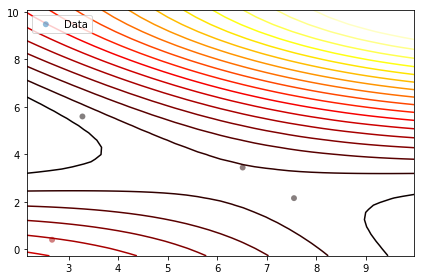

In [21]:
model.plot()

In [22]:
gauss_hermite(np.array([[0.5,0.5]]),model,3 )

(array([[0.21468066, 0.21788683, 0.22109301]]),
 array([0.16666667, 0.66666667, 0.16666667]))

## EI

In [23]:
grid = 50
x1 = np.linspace(bounds[0][0], bounds[0][1], grid)
x2 = np.linspace(bounds[1][0], bounds[1][1], grid)
X1, X2 = np.meshgrid(x1, x2)
_X = np.hstack((X1.reshape(grid*grid,1),X2.reshape(grid*grid,1)))
_Y = ei(_X, bounds, model)

In [24]:
bounds

[(0, 10), (0, 10)]

In [25]:
acq = lambda x: -1*ei(x, bounds, model)
x = minimize(acq,bounds)
x

array([[0.        , 5.55555556]])

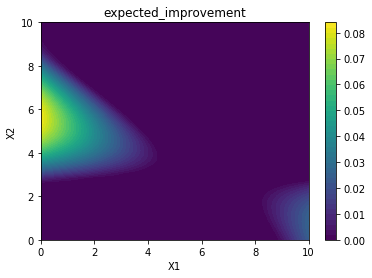

In [26]:
plt.figure()    
plt.contourf(X1, X2, _Y.reshape((grid,grid)),grid)
plt.colorbar()
plt.xlabel('X1')
plt.ylabel('X2')
plt.title("expected_improvement")
plt.show()

In [55]:
seed=4
obj_f = objective_noisy.f
kernel = GPy.kern.RBF(2, ARD=True)
np.random.seed(seed=seed)
N_q=1
N = 10
queryei, valueei = bayesianOptimization(obj_f, 
                                        ei,
                                        bounds,
                                        kernel,
                                        depth_h = h,
                                        N = N,
                                        initial_n=1,
                                        N_q = N_q
                                       )

0
1
2
3
4
5
6
7
8


In [56]:
queryei

array([[ 9.67029839,  5.47232249],
       [ 0.        ,  0.        ],
       [ 0.        ,  8.88888889],
       [ 6.66666667,  0.        ],
       [ 5.55555556, 10.        ],
       [ 3.33333333,  4.44444444],
       [10.        , 10.        ],
       [10.        ,  0.        ],
       [ 7.77777778,  2.22222222],
       [ 0.        ,  6.66666667]])

In [57]:
min(valueei)[0]

0.03194071835609225

In [58]:
from utils import gap
gap(valueei)

0.8523490001571504

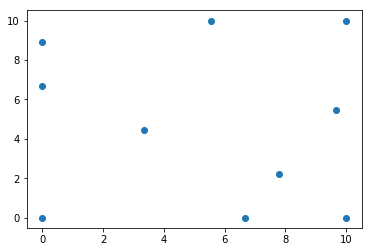

In [59]:
plt.scatter(queryei[:,0],queryei[:,1])

## Rollout 

In [60]:
grid = 10
x1 = np.linspace(bounds[0][0], bounds[0][1], grid)
x2 = np.linspace(bounds[1][0], bounds[1][1], grid)
X1, X2 = np.meshgrid(x1, x2)
_X = np.hstack((X1.reshape(grid*grid,1),X2.reshape(grid*grid,1)))

h=2
N_q=1
_Y = np.array([])
for i in range(_X.shape[0]):
    print(i)
    x = _X[i:i+1]
    y = rollout_utility_archive(x = x,
                        bounds = bounds,
                        func_policy=policy, 
                        depth_h = h, 
                        _queries = X, 
                        _values = Y, 
                        kernel=kernel,
                        N_q=N_q)
    _Y = np.concatenate([_Y,y[0]])
_Y = _Y.T

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


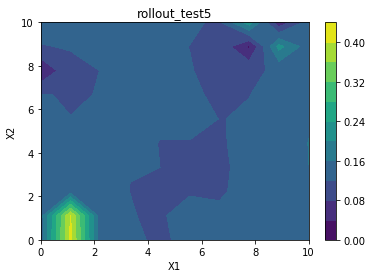

In [61]:
plt.figure()    
plt.contourf(X1, X2, _Y.reshape((grid,grid)),grid)
plt.colorbar()
plt.xlabel('X1')
plt.ylabel('X2')
plt.title("rollout_test5")
plt.show()

In [66]:
obj_f = objective_true.f
kernel = GPy.kern.RBF(2, ARD=True)
seed = 1

np.random.seed(seed=seed)

h=2
N_q=5
N = 10

queryro, valuero = bayesianOptimization(obj_f, 
                                        rollout_utility_archive,
                                        bounds,
                                        kernel,
                                        depth_h = h,
                                        N = N,
                                        N_q = N_q
                                       )

0
1
2
3
4
5
6
7
8


In [67]:
queryro

array([[ 4.17022005,  7.20324493],
       [ 6.66666667,  5.55555556],
       [ 0.        ,  8.88888889],
       [ 4.44444444,  6.66666667],
       [ 0.        ,  0.        ],
       [ 2.22222222,  7.77777778],
       [ 4.44444444,  6.66666667],
       [ 6.66666667,  7.77777778],
       [ 7.77777778,  7.77777778],
       [10.        ,  7.77777778]])

In [68]:
valuero

array([-0.76667321, -0.73421306, -0.89098825, -0.79370775,  0.0276088 ,
       -0.92570136, -0.79370775, -0.52538911, -0.49136123, -0.69035951])

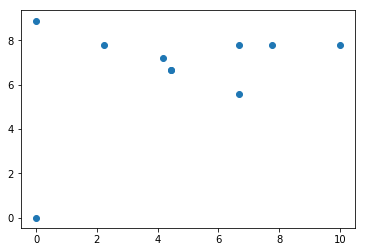

In [69]:
plt.scatter(queryro[:,0],queryro[:,1])